In [4]:
import pandas as pd

# Load files
age_csv_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/RM200-Sex-By-Single-Year-Of-Age-(Detailed)-2021-lsoa-ONS.csv"
icb_csv_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/all_icbs_2024.csv"

df_age = pd.read_csv(age_csv_path)
df_icb = pd.read_csv(icb_csv_path)

# Extract matching LSOAs
lsoa_list = df_icb["lsoa21cd"].unique()
df_age_icb_only = df_age[df_age["Lower layer Super Output Areas Code"].isin(lsoa_list)]

# Inspect results
print("---- Filtered Age CSV for ICB LSOAs ----")
print("Shape:", df_age_icb_only.shape)
print("Columns:", df_age_icb_only.columns.tolist())
print(df_age_icb_only.head())

# Optional: Check number of unique LSOAs matched
print("\nUnique LSOAs matched:", df_age_icb_only['Lower layer Super Output Areas Code'].nunique())


---- Filtered Age CSV for ICB LSOAs ----
Shape: (631904, 7)
Columns: ['Lower layer Super Output Areas Code', 'Lower layer Super Output Areas', 'Age (91 categories) Code', 'Age (91 categories)', 'Sex (2 categories) Code', 'Sex (2 categories)', 'Observation']
        Lower layer Super Output Areas Code Lower layer Super Output Areas  \
2420600                           E01014014             Herefordshire 018C   
2420601                           E01014014             Herefordshire 018C   
2420602                           E01014014             Herefordshire 018C   
2420603                           E01014014             Herefordshire 018C   
2420604                           E01014014             Herefordshire 018C   

         Age (91 categories) Code Age (91 categories)  \
2420600                         0   Aged under 1 year   
2420601                         0   Aged under 1 year   
2420602                         1         Aged 1 year   
2420603                         1         Age

In [5]:
# Identify unmatched LSOAs (to inspect any issues)
unmatched_lsoas = set(df_icb["lsoa21cd"]) - set(df_age["Lower layer Super Output Areas Code"])
print("Unmatched LSOAs:", unmatched_lsoas)


Unmatched LSOAs: set()


In [6]:
print(df_age.columns.tolist())


['Lower layer Super Output Areas Code', 'Lower layer Super Output Areas', 'Age (91 categories) Code', 'Age (91 categories)', 'Sex (2 categories) Code', 'Sex (2 categories)', 'Observation']


In [7]:
# Copy the original just in case
df_pivot = df_age_icb_only.copy()

# Create a combined column for Age × Sex
df_pivot['age_sex'] = df_pivot['Age (91 categories)'] + ' | ' + df_pivot['Sex (2 categories)']

# Pivot: one row per LSOA, one column per Age × Sex, values = Observation
df_wide = df_pivot.pivot_table(
    index=['Lower layer Super Output Areas Code', 'Lower layer Super Output Areas'],
    columns='age_sex',
    values='Observation',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Optional: clean up column names (flatten MultiIndex if needed)
df_wide.columns.name = None
df_wide.columns = [col.replace(" | ", "_").replace(" ", "_").lower() for col in df_wide.columns]

# Preview result
print("Pivoted shape:", df_wide.shape)
print(df_wide.head())


Pivoted shape: (3472, 184)
  lower_layer_super_output_areas_code lower_layer_super_output_areas  \
0                           E01014014             Herefordshire 018C   
1                           E01014031             Herefordshire 023A   
2                           E01014032             Herefordshire 023B   
3                           E01014036             Herefordshire 019B   
4                           E01014053             Herefordshire 023E   

   aged_1_year_female  aged_1_year_male  aged_10_years_female  \
0                   7                 3                    10   
1                   3                 5                    10   
2                   3                 2                     2   
3                   3                 4                    10   
4                   4                 7                     8   

   aged_10_years_male  aged_11_years_female  aged_11_years_male  \
0                   9                     8                   9   
1              

In [18]:
def extract_age_table(df_wide, sex_filter):
    df = df_wide.copy()

    if sex_filter == 'Total':
        # Combine male + female columns
        cols = [col for col in df.columns if col.endswith('_male') or col.endswith('_female')]
        base_names = set(col.replace('_male', '').replace('_female', '') for col in cols)

        for base in base_names:
            male_col = f"{base}_male"
            female_col = f"{base}_female"
            df[base] = df.get(male_col, 0) + df.get(female_col, 0)

        keep_cols = ['lower_layer_super_output_areas_code', 'lower_layer_super_output_areas'] + sorted(base_names)
        df_sex = df[keep_cols].copy()

        # Clean age labels
        age_cols_clean = []
        for col in df_sex.columns[2:]:
            label = col.replace('aged_', '').replace('_years', '').replace('_year', '').replace('_and_over', '+')
            if 'under_1' in label:
                label = '0'
            else:
                try:
                    age = int(label)
                    label = str(age)
                except ValueError:
                    label = None  # Drop anything unconvertible
            age_cols_clean.append(label)

        # Drop invalid age labels (e.g. 90+, None)
        valid_cols = [c for c in age_cols_clean if c is not None and int(c) < 90]
        df_sex.columns = ['lsoa_code', 'lsoa_name'] + age_cols_clean
        df_sex = df_sex[['lsoa_code', 'lsoa_name'] + valid_cols]

    else:
        # Male or Female
        suffix = '_male' if sex_filter == 'Male' else '_female'
        age_cols = [col for col in df.columns if col.endswith(suffix)]
        df_sex = df[['lower_layer_super_output_areas_code', 'lower_layer_super_output_areas'] + age_cols].copy()

        # Clean and filter
        new_age_cols = []
        for col in age_cols:
            label = col.replace('aged_', '').replace('_years', '').replace('_year', '').replace('_and_over', '+').replace(suffix, '').strip()
            if 'under_1' in label:
                label = '0'
            else:
                try:
                    age = int(label)
                    label = str(age)
                except ValueError:
                    label = None
            new_age_cols.append(label)

        valid_cols = [c for c in new_age_cols if c is not None and int(c) < 90]
        df_sex.columns = ['lsoa_code', 'lsoa_name'] + new_age_cols
        df_sex = df_sex[['lsoa_code', 'lsoa_name'] + valid_cols]

    # Sort final age columns
    def sort_key(age_label):
        return int(age_label) if age_label.isdigit() else 999

    age_cols = [col for col in df_sex.columns if col not in ['lsoa_code', 'lsoa_name']]
    col_order = ['lsoa_code', 'lsoa_name'] + sorted(age_cols, key=sort_key)
    return df_sex[col_order]


In [19]:
# Generate male, female, total DataFrames
df_male = extract_age_table(df_wide, sex_filter='Male')
df_female = extract_age_table(df_wide, sex_filter='Female')
df_total = extract_age_table(df_wide, sex_filter='Total')


In [20]:
import os

# Define output folder
output_folder = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/continuous_age"
os.makedirs(output_folder, exist_ok=True)

# Check head of each DataFrame
print("Male DataFrame:")
print(df_male.head(), "\n")

print("Female DataFrame:")
print(df_female.head(), "\n")

print("Total DataFrame:")
print(df_total.head(), "\n")

# Save CSVs
df_male.to_csv(os.path.join(output_folder, "lsoa_age_by_year_male.csv"), index=False)
df_female.to_csv(os.path.join(output_folder, "lsoa_age_by_year_female.csv"), index=False)
df_total.to_csv(os.path.join(output_folder, "lsoa_age_by_year_total.csv"), index=False)

print(f"Files saved to: {output_folder}")


Male DataFrame:
   lsoa_code           lsoa_name   0  1   2  3  4  5  6   7  ...  80  81  82  \
0  E01014014  Herefordshire 018C   3  3   6  8  7  6  2   6  ...   9   9   5   
1  E01014031  Herefordshire 023A   4  5   3  3  6  4  4   9  ...  12   5   7   
2  E01014032  Herefordshire 023B   6  2   5  5  6  3  5  13  ...   6   7   7   
3  E01014036  Herefordshire 019B  10  4  10  4  5  4  5   7  ...   8   6   4   
4  E01014053  Herefordshire 023E   6  7   5  6  8  4  8  10  ...   3   9   4   

   83  84  85  86  87  88  89  
0   7   3   3   1   0   6   4  
1   6   6   3   5   7   4   2  
2   2   6   3   5   3   0   3  
3   5   3   7   9   3  17   1  
4   5   2   2   2   4   3   4  

[5 rows x 92 columns] 

Female DataFrame:
   lsoa_code           lsoa_name  0  1  2  3  4  5   6   7  ...  80  81  82  \
0  E01014014  Herefordshire 018C  6  7  7  5  9  7   6   6  ...   4   4   7   
1  E01014031  Herefordshire 023A  3  3  9  8  2  7   8   5  ...   8   9   1   
2  E01014032  Herefordshire 023

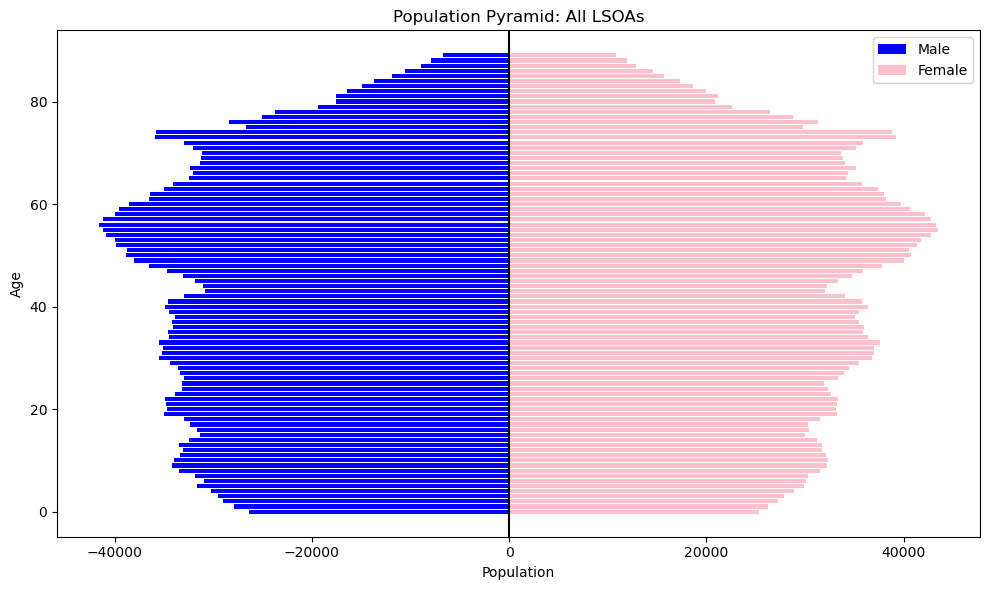

In [21]:
# Aggregate male/female by age
male_sum = df_male.drop(columns=['lsoa_code', 'lsoa_name']).sum().astype(int)
female_sum = df_female.drop(columns=['lsoa_code', 'lsoa_name']).sum().astype(int)

ages = list(map(int, male_sum.index))
male_sum.index = ages
female_sum.index = ages

plt.figure(figsize=(10, 6))
plt.barh(ages, -male_sum, color='blue', label='Male')
plt.barh(ages, female_sum, color='pink', label='Female')
plt.axvline(0, color='black')
plt.xlabel('Population')
plt.ylabel('Age')
plt.title('Population Pyramid: All LSOAs')
plt.legend()
plt.tight_layout()
plt.show()


In [23]:

# Define output folder
output_folder = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/continuous_age"
os.makedirs(output_folder, exist_ok=True)

# Growth factor for 3 years at 0.7% per year
growth_factor = (1 + 0.007) ** 3  # ≈ 1.0211

# Function to apply growth to age columns only
def apply_growth(df):
    df = df.copy()
    static_cols = ['lsoa_code', 'lsoa_name']
    age_cols = [col for col in df.columns if col not in static_cols]
    df[age_cols] = df[age_cols] * growth_factor
    return df

# Apply growth
df_male_grown = apply_growth(df_male)
df_female_grown = apply_growth(df_female)
df_total_grown = apply_growth(df_total)

# Round values if desired (optional)
df_male_grown = df_male_grown.round(2)
df_female_grown = df_female_grown.round(2)
df_total_grown = df_total_grown.round(2)

# Save updated files
df_male_grown.to_csv(os.path.join(output_folder, "lsoa_age_by_year_male_2024.csv"), index=False)
df_female_grown.to_csv(os.path.join(output_folder, "lsoa_age_by_year_female_2024.csv"), index=False)
df_total_grown.to_csv(os.path.join(output_folder, "lsoa_age_by_year_total_2024.csv"), index=False)

print(f"Growth-adjusted files saved to: {output_folder}")


Growth-adjusted files saved to: /Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/continuous_age
